#### Decision tree based ID3algorithm.


In [ ]:
import pandas as pd

from numpy.random import RandomState

df_csv = pd.read_csv('PlayTennis.csv')

rng = RandomState()

df = df_csv.sample(frac=0.7, random_state=rng)

df_testing = df_csv.loc[~df_csv.index.isin(df.index)]


print("\n Given  Data Set is:\n", df_csv)

print("\n Training Data Set is:\n", df)

print("\n Testing Data Set is:\n", df_testing)



 Given  Data Set is:
      Outlook Temperature Humidity    Wind Play Tennis
0      Sunny         Hot     High    Weak          No
1      Sunny         Hot     High  Strong          No
2   Overcast         Hot     High    Weak         Yes
3       Rain        Mild     High    Weak         Yes
4       Rain        Cool   Normal    Weak         Yes
5       Rain        Cool   Normal  Strong          No
6   Overcast        Cool   Normal  Strong         Yes
7      Sunny        Mild     High    Weak          No
8      Sunny        Cool   Normal    Weak         Yes
9       Rain        Mild   Normal    Weak         Yes
10     Sunny        Mild   Normal  Strong         Yes
11  Overcast        Mild     High  Strong         Yes
12  Overcast         Hot   Normal    Weak         Yes
13      Rain        Mild     High  Strong          No

 Training Data Set is:
      Outlook Temperature Humidity    Wind Play Tennis
11  Overcast        Mild     High  Strong         Yes
10     Sunny        Mild   Normal 

In [ ]:
t = df.keys()[-1]
print('Target Attribute is: ', t)

# Get the attribute names from input dataset
attribute_names = list(df.keys())

#Remove the target attribute from the attribute names list
attribute_names.remove(t) 
print('Predicting Attributes: ', attribute_names)

Target Attribute is:  Play Tennis
Predicting Attributes:  ['Outlook', 'Temperature', 'Humidity', 'Wind']


In [ ]:
#Function to calculate the entropy of collection S
import math
def entropy(probs):  
    return sum( [-prob*math.log(prob, 2) for prob in probs])

#Function to calulate the entropy of the given Data Sets/List with 
#respect to target attributes
def entropy_of_list(ls,value):  
    from collections import Counter
    cnt = Counter(x for x in ls)# Counter calculates the propotion of class
    print('Target attribute class count(Yes/No)=',dict(cnt))
    total_instances = len(ls)  
    print("Total no of instances/records associated with {0} is: {1}".format(value,total_instances ))
    probs = [x / total_instances for x in cnt.values()]  # x means no of YES/NO
    print("Probability of Class {0} is: {1:.4f}".format(min(cnt),min(probs)))
    print("Probability of Class {0} is: {1:.4f}".format(max(cnt),max(probs)))
    return entropy(probs) # Call Entropy 

In [ ]:
def information_gain(df, split_attribute, target_attribute,battr):
    print("\n\n-----Information Gain Calculation of ",split_attribute, " --------") 
    df_split = df.groupby(split_attribute) # group the data based on attribute values
    glist=[]
    for gname,group in df_split:
        print('Grouped Attribute Values \n',group)
        glist.append(gname) 
    
    glist.reverse()
    nobs = len(df.index) * 1.0   
    df_agg1=df_split.agg({target_attribute:lambda x:entropy_of_list(x, glist.pop())})
    df_agg2=df_split.agg({target_attribute :lambda x:len(x)/nobs})
    
    df_agg1.columns=['Entropy']
    df_agg2.columns=['Proportion']
    
    # Calculate Information Gain:
    new_entropy = sum( df_agg1['Entropy'] * df_agg2['Proportion'])
    if battr !='S':
        old_entropy = entropy_of_list(df[target_attribute],'S-'+df.iloc[0][df.columns.get_loc(battr)])
    else:
        old_entropy = entropy_of_list(df[target_attribute],battr)
    return old_entropy - new_entropy

In [ ]:
def id3(df, target_attribute, attribute_names, default_class=None,default_attr='S'):
    
    from collections import Counter
    cnt = Counter(x for x in df[target_attribute])# class of YES /NO
    
    ## First check: Is this split of the dataset homogeneous?
    if len(cnt) == 1:
        return next(iter(cnt))  # next input data set, or raises StopIteration when EOF is hit.
    
    ## Second check: Is this split of the dataset empty? if yes, return a default value
    elif df.empty or (not attribute_names):
        return default_class  # Return None for Empty Data Set
    
    ## Otherwise: This dataset is ready to be devied up!
    else:
        # Get Default Value for next recursive call of this function:
        default_class = max(cnt.keys()) #No of YES and NO Class
        # Compute the Information Gain of the attributes:
        gainz=[]
        for attr in attribute_names:
            ig= information_gain(df, attr, target_attribute,default_attr)
            gainz.append(ig)
            print('Information gain of ',attr,' is : ',ig)
        
        index_of_max = gainz.index(max(gainz))               # Index of Best Attribute
        best_attr = attribute_names[index_of_max]            # Choose Best Attribute to split on
        print("\nAttribute with the maximum gain is: ", best_attr)
        # Create an empty tree, to be populated in a moment
        tree = {best_attr:{}} # Initiate the tree with best attribute as a node 
        remaining_attribute_names =[i for i in attribute_names if i != best_attr]
        
        # Split dataset-On each split, recursively call this algorithm.Populate the empty tree with subtrees, which
        # are the result of the recursive call
        for attr_val, data_subset in df.groupby(best_attr):
            subtree = id3(data_subset,target_attribute, remaining_attribute_names,default_class,best_attr)
            tree[best_attr][attr_val] = subtree
        return tree

In [ ]:
from pprint import pprint
tree = id3(df,t,attribute_names)
print("\nThe Resultant Decision Tree is:")
pprint(tree)



-----Information Gain Calculation of  Outlook  --------
Grouped Attribute Values 
      Outlook Temperature Humidity    Wind Play Tennis
11  Overcast        Mild     High  Strong         Yes
2   Overcast         Hot     High    Weak         Yes
6   Overcast        Cool   Normal  Strong         Yes
Grouped Attribute Values 
    Outlook Temperature Humidity    Wind Play Tennis
3     Rain        Mild     High    Weak         Yes
9     Rain        Mild   Normal    Weak         Yes
5     Rain        Cool   Normal  Strong          No
13    Rain        Mild     High  Strong          No
Grouped Attribute Values 
    Outlook Temperature Humidity    Wind Play Tennis
10   Sunny        Mild   Normal  Strong         Yes
7    Sunny        Mild     High    Weak          No
0    Sunny         Hot     High    Weak          No
Target attribute class count(Yes/No)= {'Yes': 3}
Total no of instances/records associated with Overcast is: 3
Probability of Class Yes is: 1.0000
Probability of Class Yes is: 1.

In [ ]:
def predict(instance, tree,default=None): # Instance of Play Tennis with Predicted    
    attribute = next(iter(tree)) # Outlook/Humidity/Wind       
    if instance[attribute] in tree[attribute].keys(): # Value of the attributs in  set of Tree keys  
        result = tree[attribute][instance[attribute]]
        if isinstance(result, dict): # this is a tree, delve deeper
            return predict(instance, result)
        else:
            return result # this is a label
    else:
        return default

In [ ]:
df_testing['given'] =df_testing['Play Tennis']

df_testing['Play Tennis'] = df_testing['Play Tennis'].replace(['Yes','No',""],'?')

df_testing['predicted'] = df_testing.apply(predict, axis=1, args=(tree,'?')) 

print(df_testing)

     Outlook Temperature Humidity    Wind Play Tennis given predicted
1      Sunny         Hot     High  Strong           ?    No        No
4       Rain        Cool   Normal    Weak           ?   Yes       Yes
8      Sunny        Cool   Normal    Weak           ?   Yes       Yes
12  Overcast         Hot   Normal    Weak           ?   Yes       Yes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [ ]:
import numpy as np

comparison_column = np.where(df_testing["given"] == df_testing["predicted"], True, False)


print(comparison_column)
count = 0
for i in comparison_column: 
  if (i == True): 
    count = count + 1
# return count 

accuracy=count/len(comparison_column) 

print("Accuracy is:")
print(accuracy*100)

[ True  True  True  True]
Accuracy is:
100.0


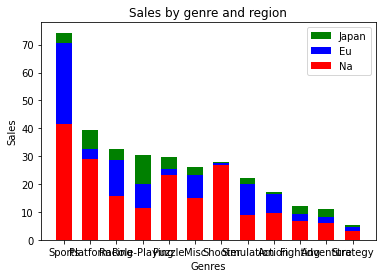

In [4]:
# import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import RandomState

df_csv = pd.read_csv('data.csv')

countries = df_csv['Genre']
bronzes = df_csv['NA_Sales']
silvers = df_csv['EU_Sales']
golds = df_csv['JP_Sales']
# ind = [country for country in countries]
 
plt.bar(ind, golds, width=0.6, label='Japan', color='green', bottom=silvers+bronzes)
plt.bar(ind, silvers, width=0.6, label='Eu', color='blue', bottom=bronzes)
plt.bar(ind, bronzes, width=0.6, label='Na', color='red')
 
# plt.xticks(ind, countries)
plt.ylabel("Sales")
plt.xlabel("Genres")
plt.legend(loc="upper right")
plt.title("Sales by genre and region")
plt.show()
